In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
idx = pd.IndexSlice
np.seterr(all='raise')

directory = r'K:\Google Drive\DESI\commissioning\sticky_pos\00047557-arc_calibration-755_disabled_noptl2'
path = os.path.join(directory, 'calibdf.pkl.gz')
calibdf = pd.read_pickle(path)['FIT']
labels = ['normal_theta', 'dead_theta', 'linear_theta', 'offset_theta', 'sticky_theta',
          'normal_phi', 'dead_phi', 'linear_phi', 'offset_phi', 'sticky_phi']
for label in labels:
    calibdf[label] = False
path = os.path.join(directory, 'movedf.pkl.gz')
movedf = pd.read_pickle(path)
for posid in calibdf.index:
    for axis in ['T', 'P']:
        moves = movedf.loc[idx[axis, :, posid]]
        # minimum (adjacent) pair separation
        calibdf.loc[posid, f'min_adj_pair_sep_{axis}'] = moves[f'exp_posint{axis}'].diff().abs().min()
        calibdf.loc[posid, f'max_err_{axis}'] = moves[f'err_posint{axis}'].abs().max()
        if axis == 'T':
            calibdf.loc[posid, 'std_adj_pair_sep_T'] = np.std(np.abs(np.diff(np.degrees(np.unwrap(np.radians(
                moves['exp_posintT'][moves['exp_posintT'].notnull()]))))))
        else:
            calibdf.loc[posid, 'std_adj_pair_sep_P'] = moves[f'exp_posint{axis}'].diff().abs().std()

In [3]:
def classify_sticky_pos(grt, grp, at, ap, rt, rp, minapst, minapsp, stdapst, stdapsp, maxet, maxep):
    '''GEAR_CALIB_T, GEAR_CALIB_P, area_T, area_P, rvalue_T, rvalue_P,
       min_adj_pair_sep_T, min_adj_pair_sep_P, std_adj_pair_sep_T, std_adj_pair_sep_P,
       'max_err_T, max_err_P'''
    labels_t, labels_p = set(), set()
    # theta arc
    if 0.8 < grt < 1.2 and at > 200 and stdapst < 14:
        labels_t.add('normal_theta')
    if at < 40 and minapst < 30:
        labels_t.add('dead_theta')
    if at > 30 and minapst < 38 and stdapst > 4 and grt > 0.6:
        labels_t.add('offset_theta')
    if 0.2<abs(grt-1)<0.95 and abs(rt) > 0.97 and minapst > 1 and 4< stdapst < 15:
        labels_t.add('linear_theta')
    if not labels_t:
        labels_t.add('sticky_theta')
    # phi arc
    if (grp < 0.3 or 1.3 < grp) and ap < 1 and minapsp < 5:
        labels_p.add('dead_phi')
    if abs(grp-1) > 0.12 and ap > 1 and abs(rp) > 0.97:
        labels_p.add('linear_phi')
    if abs(grp-1) > 0.06 and 1 < ap < 5.7 and abs(rp) < 0.97 and minapsp > 4 and stdapsp > 1:
        labels_p.add('sticky_phi')  # M01484
    if abs(grp-1) < 0.12 and ap > 3 and minapsp > 5 and maxep < 3.5 and stdapsp < 1:
        labels_p.add('normal_phi')
    if ap > 2 and minapsp < 13 and stdapsp > 1:  # grp can be 0
        labels_p.add('offset_phi')  # M00469, M01497
    if not len(labels_t) == len(labels_p) == 1:
        print(labels_t, labels_p)
    if ((len(labels_t) != 1 and labels_t != {'offset_theta', 'linear_theta'})
        or (len(labels_p) != 1 and (labels_p != {'offset_phi', 'linear_phi'} and labels_p != {'offset_phi', 'sticky_phi'}))):
        import pdb; pdb.set_trace()
    return labels_t, labels_p

In [4]:
for posid in calibdf.index:
    row = calibdf.loc[posid, ['GEAR_CALIB_T', 'GEAR_CALIB_P', 'area_T', 'area_P', 'rvalue_T', 'rvalue_P',
                              'min_adj_pair_sep_T', 'min_adj_pair_sep_P', 'std_adj_pair_sep_T', 'std_adj_pair_sep_P',
                              'max_err_T', 'max_err_P']]
    labels_t, labels_p = classify_sticky_pos(*row)
    for label in labels_t | labels_p:
        calibdf.loc[posid, label] = True

{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'offset_theta'} {'offset_phi', 'sticky_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'sticky_theta'} {'offset_phi', 'sticky_phi'}
{'normal_theta'} {'offset_phi', 'linear_phi'}
{'normal_theta'} {'offset_phi', 'l

In [15]:
calibdf.query('linear_phi==True')['GEAR_CALIB_P'].sort_values()

DEVICE_ID
M03979    0.145726
M07119    0.197515
M07715    0.215596
M05132    0.219511
M03940    0.219885
            ...   
M04381    0.696219
M04309    0.715125
M06933    0.724425
M03961    0.730507
M03947    0.767029
Name: GEAR_CALIB_P, Length: 213, dtype: float64

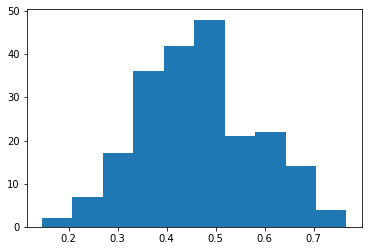

In [17]:
_ = plt.hist(calibdf.query('linear_phi==True')['GEAR_CALIB_P'])

In [44]:
calibdf[['rvalue_P', 'pvalue_P']]

field,rvalue_P,pvalue_P
DEVICE_ID,,
M00411,-0.297599,5.667804e-01
M00436,-0.999896,1.633803e-08
M00469,-0.916383,1.019535e-02
M00636,0.436850,3.864086e-01
M01033,0.925632,8.090192e-03
...,...,...
M08230,-0.986805,2.600009e-04
M08249,0.403951,4.270313e-01
M08299,-0.970956,1.253116e-03


In [6]:
posids = calibdf[calibdf["normal_theta"] & calibdf["normal_phi"]].index
print(f'normal theta and phi ({len(posids)} positioners):\n\n{", ".join(posids)}\n')
for label in labels:
    posids = calibdf[calibdf[label] == True].index
    print(f'{label} ({len(posids)} positioners):\n\n{", ".join(posids)}\n')

normal theta and phi (332 positioners):

M00411, M00636, M01033, M01081, M01092, M01094, M01100, M01109, M01133, M01214, M01222, M01224, M01228, M01257, M01267, M01380, M01455, M01473, M01540, M01605, M01630, M01691, M01703, M01713, M01717, M01724, M01747, M01786, M01789, M01808, M01841, M01859, M01862, M01934, M02023, M02024, M02031, M02117, M02128, M02194, M02249, M02257, M02258, M02261, M02272, M02286, M02287, M02300, M02301, M02317, M02318, M02334, M02345, M02349, M02353, M02373, M02378, M02382, M02392, M02397, M02401, M02413, M02427, M02459, M02467, M02472, M02476, M02484, M02492, M02514, M02523, M02533, M02537, M02542, M02543, M02566, M02572, M02575, M02577, M02580, M02587, M02596, M02598, M02601, M02606, M02610, M02624, M02641, M02649, M02651, M02654, M02666, M02673, M02677, M02682, M02699, M02704, M02720, M02724, M02737, M02781, M02801, M02818, M02824, M02832, M02834, M02835, M02846, M02849, M02851, M02857, M02871, M02902, M02904, M02913, M02915, M02919, M02922, M02926, M02937,

In [27]:
directory = r'K:\Google Drive\DESI\commissioning\sticky_pos'
path = os.path.join(directory, 'movedf.pkl.gz')
movedf = pd.read_pickle(path)

In [40]:
movedf.xs('M04462', level='DEVICE_ID')[['tgt_x', 'tgt_y', 'status_0']]

,tgt_x,tgt_y,status_0
target_no,,,
0,-1.5,-1.5,Normal positioner
1,-1.5,-0.5,Normal positioner
2,-0.5,-0.5,Unreachable by positioner
3,0.5,1.5,Normal positioner
4,0.5,-1.5,Normal positioner
5,0.5,-0.5,Unreachable by positioner
6,-0.5,-1.5,Normal positioner
7,1.5,0.5,Normal positioner
8,-1.5,0.5,Normal positioner


In [7]:
directory = r'K:\Google Drive\DESI\commissioning\sticky_pos'
path = os.path.join(directory, 'gradedf.pkl.gz')
gradedf = pd.read_pickle(path)

In [8]:
posids1 = calibdf[calibdf["normal_theta"] & calibdf["normal_phi"]].index
posids2 = gradedf[gradedf['err_0_max'] < 200].index

In [26]:
gradedf.loc['M03600']

err_0_max                                           52.8185
err_corr_max                                            NaN
err_corr_rms                                            NaN
err_corr_95p_max                                        NaN
err_corr_95p_rms                                        NaN
grade                                                   N/A
PETAL_LOC                                                 4
DEVICE_LOC                                              510
BUS_ID                                                can14
PCID                                                      4
LENGTH_R1                                           3.10613
LENGTH_R2                                           2.91077
OFFSET_X                                            352.123
OFFSET_Y                                            167.839
OFFSET_T                                            38.7248
OFFSET_P                                           -16.9154
targetable_range_T    [-193.393915117201

In [19]:
len(posids2)

313

In [24]:
gradedf.loc[posids2].describe()

,err_0_max,err_corr_max,err_corr_rms,err_corr_95p_max,err_corr_95p_rms,PETAL_LOC,DEVICE_LOC,PCID,LENGTH_R1,LENGTH_R2,OFFSET_X,OFFSET_Y,OFFSET_T,OFFSET_P
count,313.000000,0.0,0.0,0.0,0.0,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,66.774123,NaN,NaN,NaN,NaN,6.185304,259.482428,6.185304,2.979301,3.018604,254.858559,85.358292,11.373268,-3.549093
std,29.358311,NaN,NaN,NaN,NaN,2.670622,142.755463,2.670622,0.116971,0.066210,80.415716,54.397421,101.819863,4.059182
min,25.127928,NaN,NaN,NaN,NaN,0.000000,2.000000,0.000000,2.574578,2.798287,33.447776,5.169772,-177.398589,-19.888994
25%,47.981537,NaN,NaN,NaN,NaN,5.000000,152.000000,5.000000,2.914394,2.976854,210.451227,32.398908,-76.718003,-4.986229
50%,57.663616,NaN,NaN,NaN,NaN,8.000000,256.000000,8.000000,2.967686,3.016188,267.861155,86.434031,22.367906,-2.812721
75%,78.733204,NaN,NaN,NaN,NaN,8.000000,368.000000,8.000000,3.023292,3.055193,304.464017,131.635098,95.866005,-1.267241
max,195.944911,NaN,NaN,NaN,NaN,9.000000,526.000000,9.000000,3.780044,3.210465,404.698580,194.995446,179.711760,9.835344


In [18]:
print(", ".join(posids2))

M04441, M05252, M05766, M05767, M05814, M05831, M05872, M05882, M05923, M05932, M06590, M06711, M06768, M07339, M07679, M07847, M07915, M07916, M07917, M07942, M07946, M07947, M07963, M07970, M08027, M08030, M08054, M08058, M08135, M08156, M08180, M01380, M02287, M02580, M03247, M02334, M04250, M04369, M04596, M01133, M01222, M01224, M01713, M01747, M02194, M02272, M02318, M02345, M02641, M02654, M02899, M02926, M02981, M03034, M03217, M03219, M03253, M03277, M03600, M03602, M03612, M03707, M03977, M04093, M04116, M04366, M04510, M04550, M04761, M04873, M05322, M05486, M01228, M01257, M01841, M02349, M03029, M03271, M03507, M04244, M04759, M05629, M05779, M05936, M06195, M06198, M06201, M06212, M06497, M06499, M06815, M06821, M06854, M06875, M06883, M06889, M06963, M06976, M07034, M07116, M07120, M07122, M07142, M07169, M07238, M07243, M07259, M07261, M07313, M07466, M07473, M07475, M07599, M07600, M07757, M00411, M01934, M02373, M02624, M04408, M05711, M05747, M06090, M06548, M06786, 

In [11]:
len(posids1)

332

In [12]:
len(posids2)

313

In [13]:
posids = set(posids1) & set(posids2)

In [15]:
set(posids2) ^ posids

{'M02899', 'M04596', 'M05322', 'M05882'}

In [10]:
ok = ['M00411', 'M00636', 'M01033', 'M01081', 'M01092', 'M01094', 'M01100', 'M01109', 'M01133', 'M01214', 'M01222', 'M01224', 'M01228', 'M01257', 'M01267', 'M01455', 'M01473', 'M01540', 'M01605', 'M01630', 'M01691', 'M01703', 'M01713', 'M01717', 'M01724', 'M01747', 'M01786', 'M01789', 'M01808', 'M01841', 'M01859', 'M01862', 'M01934', 'M02023', 'M02024', 'M02031', 'M02117', 'M02128', 'M02194', 'M02249', 'M02257', 'M02258', 'M02261', 'M02272', 'M02286', 'M02287', 'M02300', 'M02301', 'M02317', 'M02318', 'M02334', 'M02345', 'M02349', 'M02353', 'M02373', 'M02378', 'M02382', 'M02392', 'M02397', 'M02401', 'M02413', 'M02427', 'M02459', 'M02472', 'M02476', 'M02484', 'M02492', 'M02514', 'M02523', 'M02533', 'M02537', 'M02542', 'M02543', 'M02566', 'M02572', 'M02575', 'M02577', 'M02580', 'M02587', 'M02596', 'M02598', 'M02601', 'M02606', 'M02610', 'M02624', 'M02641', 'M02649', 'M02651', 'M02654', 'M02666', 'M02682', 'M02699', 'M02704', 'M02724', 'M02737', 'M02781', 'M02801', 'M02818', 'M02824', 'M02832', 'M02834', 'M02835', 'M02846', 'M02849', 'M02851', 'M02857', 'M02871', 'M02899', 'M02902', 'M02904', 'M02913', 'M02919', 'M02922', 'M02926', 'M02937', 'M02939', 'M02969', 'M02974', 'M02976', 'M02981', 'M03001', 'M03012', 'M03018', 'M03019', 'M03029', 'M03030', 'M03034', 'M03045', 'M03072', 'M03117', 'M03121', 'M03137', 'M03197', 'M03212', 'M03216', 'M03217', 'M03219', 'M03247', 'M03253', 'M03271', 'M03277', 'M03304', 'M03317', 'M03342', 'M03343', 'M03352', 'M03367', 'M03371', 'M03374', 'M03417', 'M03507', 'M03527', 'M03561', 'M03570', 'M03602', 'M03612', 'M03707', 'M03977', 'M04093', 'M04104', 'M04105', 'M04116', 'M04200', 'M04242', 'M04244', 'M04250', 'M04275', 'M04276', 'M04366', 'M04369', 'M04377', 'M04397', 'M04398', 'M04436', 'M04441', 'M04453', 'M04458', 'M04470', 'M04481', 'M04510', 'M04526', 'M04531', 'M04550', 'M04562', 'M04563', 'M04566', 'M04586', 'M04592', 'M04596', 'M04618', 'M04623', 'M04624', 'M04701', 'M04759', 'M04761', 'M04771', 'M04801', 'M04873', 'M04909', 'M04910', 'M04912', 'M04914', 'M04916', 'M04917', 'M04924', 'M04960', 'M05076', 'M05093', 'M05098', 'M05101', 'M05106', 'M05124', 'M05126', 'M05127', 'M05158', 'M05167', 'M05177', 'M05244', 'M05252', 'M05304', 'M05316', 'M05322', 'M05371', 'M05402', 'M05403', 'M05459', 'M05486', 'M05505', 'M05517', 'M05524', 'M05551', 'M05583', 'M05629', 'M05711', 'M05747', 'M05766', 'M05767', 'M05779', 'M05814', 'M05831', 'M05872', 'M05923', 'M05932', 'M05936', 'M05958', 'M06090', 'M06195', 'M06198', 'M06201', 'M06212', 'M06497', 'M06499', 'M06548', 'M06590', 'M06711', 'M06768', 'M06786', 'M06794', 'M06815', 'M06821', 'M06854', 'M06875', 'M06883', 'M06889', 'M06963', 'M06976', 'M07034', 'M07116', 'M07120', 'M07122', 'M07142', 'M07169', 'M07238', 'M07243', 'M07251', 'M07259', 'M07261', 'M07313', 'M07339', 'M07466', 'M07473', 'M07475', 'M07494', 'M07589', 'M07590', 'M07599', 'M07600', 'M07679', 'M07757', 'M07847', 'M07913', 'M07915', 'M07916', 'M07917', 'M07942', 'M07946', 'M07947', 'M07963', 'M07970', 'M08027', 'M08030', 'M08054', 'M08058', 'M08135', 'M08156', 'M08180', 'M08208']

In [19]:
posids = list(posids)
print(f'good calibration and xytest blind move error < 200 microns ({len(posids)} positioners):\n\n{", ".join(posids)}\n')

good calibration and xytest blind move error < 200 microns (309 positioners):

M01862, M04550, M04771, M03018, M01222, M02566, M01267, M04586, M04408, M04453, M07589, M03271, M01473, M06963, M02801, M07238, M02472, M05177, M05831, M07251, M04910, M03034, M04458, M03029, M04526, M07599, M01841, M05158, M01224, M04592, M01747, M04623, M03012, M02682, M03137, M07679, M02543, M02922, M03707, M05098, M05747, M05932, M04960, M07947, M06497, M05923, M01033, M06195, M02919, M06794, M03277, M01786, M03072, M02835, M02832, M01703, M04398, M03197, M02575, M07473, M08156, M07970, M02334, M02624, M05371, M06875, M01109, M07600, M07963, M02939, M01092, M04124, M04873, M02492, M02577, M02596, M07116, M07942, M04914, M04562, M04244, M06201, M05459, M02610, M01257, M03602, M02317, M04200, M04470, M03507, M02287, M05127, M03117, M03217, M02824, M05076, M05505, M02413, M02851, M02523, M02937, M04912, M03343, M02128, M07946, M04436, M05093, M01934, M03030, M01789, M05167, M08058, M07142, M01100, M02818, M

['M01862', 'M04550', 'M04771', 'M03018', 'M01222', 'M02566', 'M01267', 'M04586', 'M04408', 'M04453', 'M07589', 'M03271', 'M01473', 'M06963', 'M02801', 'M07238', 'M02472', 'M05177', 'M05831', 'M07251', 'M04910', 'M03034', 'M04458', 'M03029', 'M04526', 'M07599', 'M01841', 'M05158', 'M01224', 'M04592', 'M01747', 'M04623', 'M03012', 'M02682', 'M03137', 'M07679', 'M02543', 'M02922', 'M03707', 'M05098', 'M05747', 'M05932', 'M04960', 'M07947', 'M06497', 'M05923', 'M01033', 'M06195', 'M02919', 'M06794', 'M03277', 'M01786', 'M03072', 'M02835', 'M02832', 'M01703', 'M04398', 'M03197', 'M02575', 'M07473', 'M08156', 'M07970', 'M02334', 'M02624', 'M05371', 'M06875', 'M01109', 'M07600', 'M07963', 'M02939', 'M01092', 'M04124', 'M04873', 'M02492', 'M02577', 'M02596', 'M07116', 'M07942', 'M04914', 'M04562', 'M04244', 'M06201', 'M05459', 'M02610', 'M01257', 'M03602', 'M02317', 'M04200', 'M04470', 'M03507', 'M02287', 'M05127', 'M03117', 'M03217', 'M02824', 'M05076', 'M05505', 'M02413', 'M02851', 'M02523',

In [11]:
len(posids)

309

In [14]:
for posid in posids ^ set(ok):
    print(f'{posid} Duan wants to enable: {str(posid in posids):>5}, Parker wants to enable: {str(posid in ok):>5}')

M04408 Duan wants to enable:  True, Parker wants to enable: False
M05322 Duan wants to enable: False, Parker wants to enable:  True
M04596 Duan wants to enable: False, Parker wants to enable:  True
M02899 Duan wants to enable: False, Parker wants to enable:  True
M04124 Duan wants to enable:  True, Parker wants to enable: False
M03600 Duan wants to enable:  True, Parker wants to enable: False
M04462 Duan wants to enable:  True, Parker wants to enable: False
M01380 Duan wants to enable:  True, Parker wants to enable: False
